In [22]:
import librosa, librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

## SSA

# Описание алгоритма

## Постановка задачи

Наблюдается система функций дискретного аргумента {$(f_i^{(k)})_{i=1}^N$, где k = 1, ..., s}. s —- число временных рядов, k —- номер ряда, N —- длина временного ряда, i —- номер отсчета. Требуется разложить ряд в сумму компонент (используя метод главных компонент, см. описание алгоритма), интерпретировать каждую компоненту, и построить продолжение ряда $(f_i^{(k)})_{i=1}^{N+M}$ по выбранным компонентам.

## Построение матрицы наблюдений

Рассмотрим сначала одномерный временной ряд $(f_i)_{i=1}^N.$ Выберем n такое, что $0 < n \le N - 1$ —- время жизни многомерной гусеницы. Пусть $\sigma = N - n + 1$ —- длина гусеницы. Построим последовательность из n векторов в $R^{\sigma}$ следующего вида:

$$Y^{(l)} \in R^{\sigma},$$
$$Y^{(l)} = (f_{i+l-1})_{i=1}^{\sigma}$$

Обозначим

$$Z = (Y^{(1)}, \ldots, Y^{(n)}):$$

Будем называть $Z$ нецентрированной матрицей наблюдений, порождённой гусеницей со временем жизни n.

В случае многомерного временного ряда матрицей наблюдения называется столбец из матриц наблюдений, соответствующих каждой из компонент.

Проводимый в дальнейшем анализ главных компонент может проводиться как по центрированной, так и по нецентрированной выборкам. Для упрощения выкладок рассмотрим простейший нецентрированный вариант.

## Анализ главных компонент

Рассмотрим ковариационную матрицу полученной выборки:

$$C = \frac1n ZZ^T.$$

Выполним её svd-разложение:

$$C = V\Lambda V^T,$$

где $\Lambda = diag(\lambda_1, \ldots, \lambda_{\tau})$ —- диагональная матрица собственных чисел, $V = (v^{(1)}, \ldots, v^{(\tau)})$, $(v^{(i)})^T v^{(j)} = \delta_{ij}$ —- ортогональная матрица собственных векторов.

Далее рассмотрим систему главных компонент:

$$U = V^T Z, U = (U^{(1)}, \ldots, U^{(\tau)})^T.$$

## Прогноз

Числовой ряд $(f_i)_{i=1}^{N+1}$ называется продолжением ряда $(f_i)_{i=1}^N$, если порождаемая им при гусеничной обработке выборка лежит в той же гиперплоскости, что и у исходного ряда. Пусть у нас есть некоторый набор выбранных главных компонент $i_1, i_2, \ldots, i_r.$ Определим

$$w = \left ( \begin{array}{cccc} v_{\sigma}^{(i_1)}&v_{\sigma}^{(i_2)}&\ldots&v_{\sigma}^{(i_r)}\\ v_{2\sigma}^{(i_1)}&v_{2\sigma}^{(i_2)}&\ldots&v_{2\sigma}^{(i_r)}\\ \vdots& \vdots &\ddots & \vdots\\ v_{\tau}^{(i_1)}&v_{\tau}^{(i_2)}&\ldots&v_{\tau}^{(i_r)}\end{array} \right ) $$

и

$$ V_* = \left ( \begin{array}{cccc}
v_1^{(i_1)}&v_1^{(i_2)}&\ldots&v_1^{(i_r)}\\ \vdots& \vdots &\ddots & \vdots\\ v_{\sigma - 1}^{(i_1)}&v_{\sigma - 1}^{(i_2)}&\ldots&v_{\sigma - 1}^{(i_r)}\\ v_{\sigma + 1}^{(i_1)}&v_{\sigma + 1}^{(i_2)}&\ldots&v_{\sigma + 1}^{(i_r)}\\ \vdots& \vdots &\ddots & \vdots\\ v_{2\sigma - 1}^{(i_1)}&v_{2\sigma - 1}^{(i_2)}&\ldots&v_{2\sigma - 1}^{(i_r)}\\ \vdots& \vdots &\ddots & \vdots\\ v_{\tau - 1}^{(i_1)}&v_{\tau - 1}^{(i_2)}&\ldots&v_{\tau - 1}^{(i_r)}\end{array} \right ) $$

Также положим

$$Q = \left (f_{N-\sigma+2}^{(1)}, \ldots, f_N^{(1)}, f_{N-\sigma+2}^{(2)}, \ldots, f_N^{(2)}, \ldots, f_{N-\sigma+2}^{(s)}, \ldots, f_N^{(s)}\right )^T$$

Тогда прогнозируемые значения системы в точке $N+1$ вычисляются по формуле:

$$f_{N+1} = w(V_*^T V_*)^{-1} V_*^T Q.$$

## Тестовый прогноз

Протестируем алгоритм на тестовом временном ряде, синтезируемом как сумма линейной компоненты (тренда), двух сезонных компонент (синусоид разной частоты) и нормального шума. На графике представлен исходный временной ряд (синий) и прогнозируемый с помощью алгоритма SSA (красный):

In [24]:
def ssa_predict_n_times(x, n_forward, n_emb, n_comp):
    def ssa(x, n_emb, n_comp):
        X = np.empty((len(x) - n_emb, n_emb))
        for i in range(n_emb):
            X[:, i] = x[i:i - n_emb]

        V1, _, _ = np.linalg.svd(X.T.dot(X) / n_emb)

        V_star = V1[:-1, :n_comp]
        V_tau = V1[-1, :n_comp]
        Q = x[-n_emb + 1:]
        return V_tau.dot(V_star.T).dot(Q) / (1 - V_tau.dot(V_tau))
    with tqdm(total=n_forward) as pbar:
        for _ in range(n_forward):
            x = np.concatenate([x, [ssa(x, n_emb, n_comp)]])
            pbar.update(1)
    return x

In [25]:
import pandas as pd

In [26]:
df = pd.read_csv('GermanSpotPrice.csv')

In [42]:
res = ssa_predict_n_times(x, 1, 1000, 50)

100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


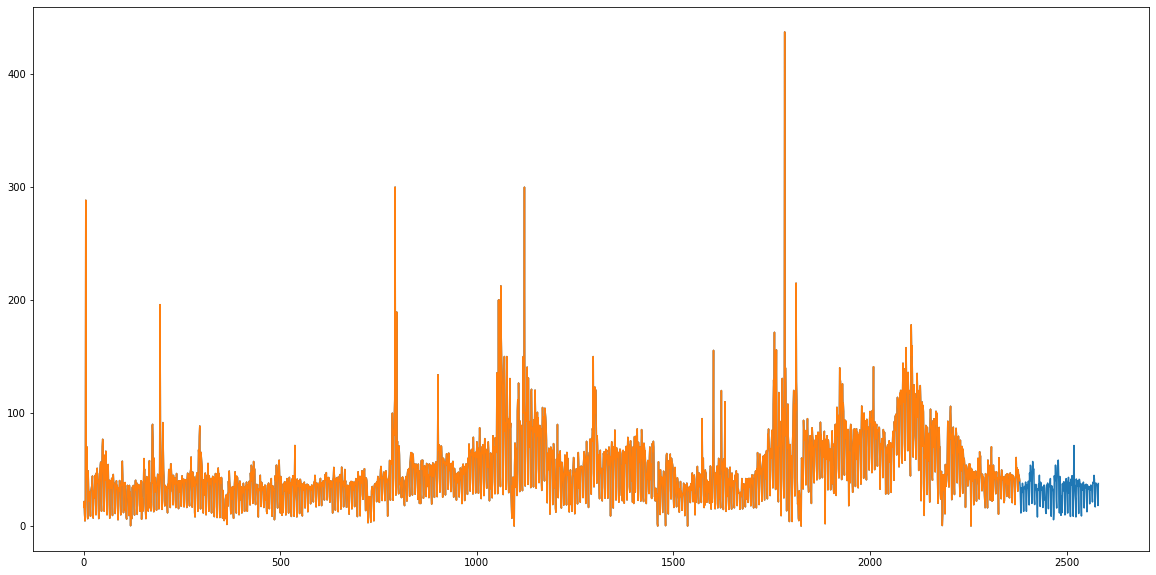

In [40]:
fig = plt.figure(figsize = (20, 10))
plt.plot(a)
plt.plot(x)